# SimCLR

Multi-backends version.

In [1]:
# %xmode minimal

import os
import json

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

import os
os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models

import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

# Turn off logging for TF
import logging
tf.get_logger().setLevel(logging.ERROR)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

from keras import layers, models, ops, losses, metrics

from keras.applications import resnet

# from keras.applications import vgg16

2024-06-18 12:51:51.637414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# tf.config.experimental_run_functions_eagerly(True)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())


In [3]:
import dpmhm
# dpmhm.datasets.get_dataset_list()
from dpmhm.datasets import preprocessing, transformer, feature, utils
# from dpmhm.models import byol, simclr

workdir = Path("/home/han/tmp/SimCLR/")
os.makedirs(workdir, exist_ok=True)

In [4]:
def NT_Xent_loss(zi, zj, tau:float=0.5, axis:int=1) -> float:
    """Normalized Temperature-scaled Cross Entropy Loss.

    We modify the original definition by excluding also the term of index `j` from the denominator. This is closer to the initial aim of NT-Xent to pull together positive pairs (between `i` and `j`) while pushing apart negative pairs (not including `j`).

    Parameters
    ----------
    zi
        Anchor samples
    zj
        Augmented samples
    tau, optional
        Temperature, by default 0.5. A small temperature implies a sharper distribution in the feature space.
    axis, optional
        Axis of feature, by default 1
    """
    zi = ops.normalize(zi, axis=axis)
    zj = ops.normalize(zj, axis=axis)
    # print('shape after=', zi.shape, zj.shape)

    # Cosine similarity
    # between anchor - anchor
    Sii = ops.matmul(zi, ops.transpose(zi)) / tau
    # between anchor - augmented
    Sij = ops.matmul(zi, ops.transpose(zj)) / tau

    P = ops.diag(Sij)
    N = Sii - ops.diag(Sii) + Sij - ops.diag(Sij)

    return ops.sum(ops.logsumexp(N, axis=axis) - P)


def _loss(y_true, y_pred):
    y1, y2 = y_pred[0], y_pred[1]
    # y1 = ops.take(y_pred, 0, axis=0)
    # y2 = ops.take(y_pred, 1, axis=0)
    return NT_Xent_loss(y1, y2) + NT_Xent_loss(y2, y1)

# _loss = lambda y_true, y_pred: NT_Xent_loss(y_pred[0], y_pred[1]) + NT_Xent_loss(y_pred[1], y_pred[0])

In [5]:
class SimCLR(keras.Model):
    def __init__(self, input_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._encoder = resnet.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
        self._encoder.trainable = False

        self. _projector = models.Sequential([
            # A dense layer applies only on the last dimension while preserving all other dimensions as batch.
            layers.Flatten(name='flatten'),
            layers.Dense(256, activation='relu', name='fc1'),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu', name='fc2'),
            layers.BatchNormalization(),
            layers.Dense(64, activation=None, name='fc3'),
        ], name='Projection_head')

    def call(self, inputs, training=True):
        x1, x2 = inputs  # ok if inputs is tuple, error in tensorflow's autograph mode: iterating on a tensor
        # x1, x2 = inputs[0], inputs[1]  # not considered as iterating on a tensor
        #
        # if `inputs` is packed into a single tensor
        # x1 = ops.take(inputs, 0, axis=1)
        # x2 = ops.take(inputs, 1, axis=1)

        y1 = self._projector(self._encoder(x1), training=training)
        y2 = self._projector(self._encoder(x2), training=training)

        # return y1, y2  # error: only y1 is passed to the loss function
        return ops.stack([y1, y2])

## Load Data

In [6]:
ds_name = 'CWRU'

dpmhm.datasets.query_parameters(ds_name)

{'signal': {'DE': 1, 'FE': 1, 'BA': 1},
 'sampling_rate': [12000, 48000],
 'keys': {'FaultLocation': {'DriveEnd', 'FanEnd', 'None'},
  'FaultComponent': {'Ball',
   'InnerRace',
   'None',
   'OuterRace12',
   'OuterRace3',
   'OuterRace6'},
  'FaultSize': {0, 0.007, 0.014, 0.021, 0.028}},
 'filters': {'LoadForce': {0, 1, 2, 3}},
 'type': 'initiated',
 'split': ['train']}

In [7]:
ds0 = tfds.load(
    ds_name,
    # split='',
    # split=['train[:75%]', 'train[75%:]'],
    # split=[split1, split2],
    split='all',
    # download=True,  #
    # with_info=True,
    # batch_size=-1,  # load the whole dataset into a single batch
)

# ds0 = ds_all['train']
ds_size = utils.get_dataset_size(ds0)

channels = ['DE', 'FE', 'BA']  # will rule out the normal data

keys = ['FaultComponent', 'FaultSize', 'FaultLocation']

# Feature extractor
_func = lambda x, sr: feature.spectral_features(
    x, sr, 'spectrogram',
    time_window=0.025,
    hop_step=0.0125,
    normalize=False,
    to_db=True)[0]

# _func = lambda x, sr: feature.spectral_features(
#     x, sr, 'melspectrogram',
#     time_window=0.025, hop_step=0.0125, normalize=False,
#     feature_kwargs={'n_mels':128})[0]

compactor = transformer.DatasetCompactor(ds0, keys=keys, channels=channels)
labels = list(compactor.full_label_dict.keys())

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# product = transformer.Product(specaugment.dataset, keys=['FileName'], positive=True)

# slider = transformer.WindowSlider(extractor.dataset, window_shape=64, downsample=64)
# # fp = tempfile.mkdtemp()
# # slider.serialize(str(workdir), compression='GZIP')
# slider.dataset = tf.data.Dataset.load(str(workdir), compression='GZIP')

# slider.dataset.cardinality()
# preproc = preprocessing.get_mapping_supervised(labels)
# ds1 = utils.restore_shape(
#     specaugment.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)
# )

2024-06-18 12:51:52.548080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 12:51:53.733647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 12:51:53.970254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 12:51:54.199143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### SpecAugment and Paired dataset

For any spectral sample `x`, we apply the spectrogram augmentation provided in `transformer` and build a paired dataset of form `(x1, x2)` for SSL.

Notably, the paired dataset preserve the randomness: a paired sample `(x1, x2)` is two randomly transformed version of a common `x`. Let's check this:

Alternatively, the spectrogram augmentation can be implemented also via keras preprocessing layers as follows 

```python
layer_zoom = keras.layers.RandomZoom((-.5,.5), fill_mode='reflect')
layer_flip = keras.layers.RandomFlip(mode='horizontal')
layer_crop = keras.layers.RandomCrop(64, 64)

layer_flip(layer_crop(layer_zoom(X)))
```

2024-06-18 12:51:55.896356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


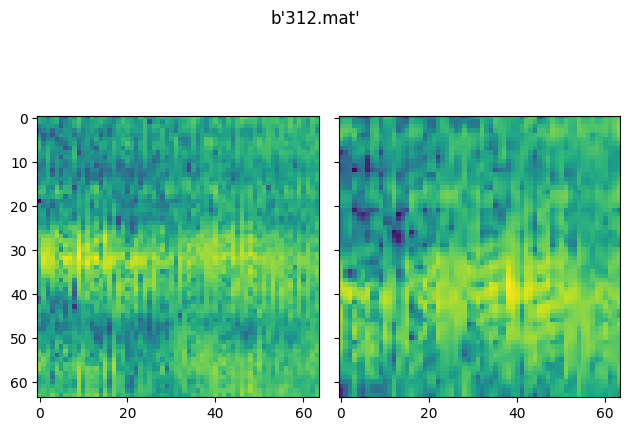

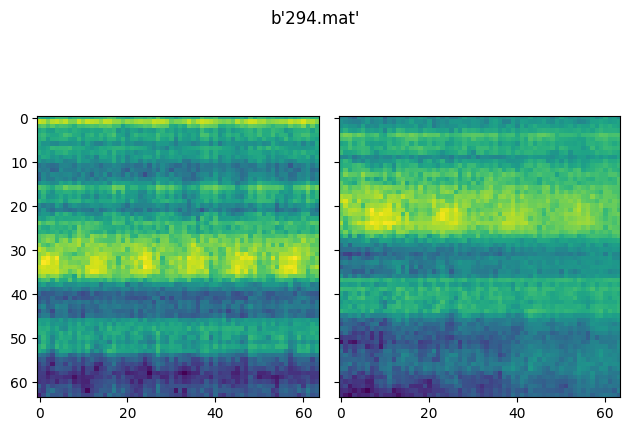

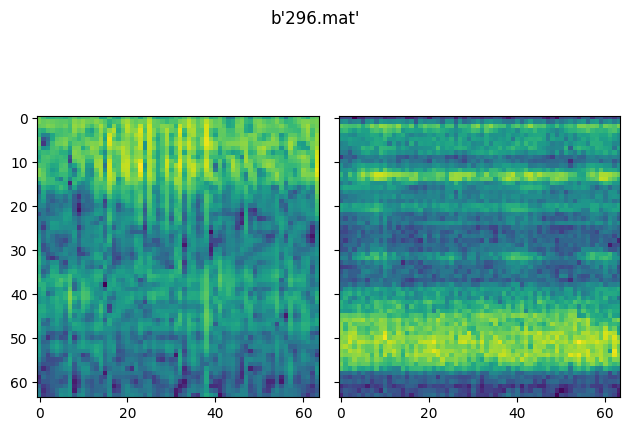

In [8]:
specaugment = transformer.SpecAugment(extractor.dataset)

ds1 = specaugment.dataset
# Paired dataset
ds2 = tf.data.Dataset.zip(ds1, ds1)

for e1, e2 in ds2.take(3):
    assert(e1['metadata']==e2['metadata'])
    X1 = e1['feature'][0]
    X2 = e2['feature'][0]

    fig, axes = plt.subplots(1,2,sharey=True)
    axes[0].imshow(X1)
    axes[1].imshow(X2)
    fig.suptitle(e1['metadata']['FileName'].numpy())
    fig.tight_layout()

### Dataset with fake labels

The paired dataset of element type `(x1, x2)` passed to the SimCLR model will be transformed to `(y1, y2)`. Unfortunately the later incompatible with the loss function `loss(y_true, y_pred)` accepted by Keras. Actually, there is no `y_true` in our case and `y_pred` should be `(y1, y2)`. 

One solution (also put forward by the official documentation of Keras) is to customize the method `train_step()` which is backend dependent, like in

https://keras.io/guides/custom_train_step_in_tensorflow/

 A simpler solution avoids the customization and only needs to adapt `call()` and the loss function, like follows

1. From the original paired dataset build a dataset of type `((x1, x2), fake_label)` as input to the SimCLR model's `.call()`. Optionally the part `(x1, x2)` can be stacked in a single tensor (possibly of higher dimension) to avoid any implicite compile time error, using `.map()` on `tf.stack([x1, x2])`.
2. In `.call(inputs)` separate `x1` and `x2` from `inputs` as `x1, x2 = inputs[0], inputs[1]`. This is safer than `x1, x2 = inputs` which may complain when use Tensorflow as backend. For stacked inputs, use instead `ops.take()`. On the other hand, the output of `.call()` must be a single tensor like `ops.stack([y1, y2])`.
3. The loss function's signature is always `loss(y_true, y_pred)`, although it doesn't use the fake label `y_true` at all. `y1` and `y2` needed by the original loss are obtained again by splitting `y_pred` using `ops.take()`. 

Then one can call `model.fit()` on the dataset `((x1, x2), fake_label)` for training, independant of the backend.

The logic behind this solution is that the `Model` class in Keras is actually designed for supervised learning, of type `y=f(x)`. A customized Keras model implements `f` in the method `.call(x)`, which should not be confused with `.fit(x,y)`. The argument `inputs` to `.call(inputs)` can be a tuple, but the output has to be a single tensor (if the output has several terms then only the first is passed to the loss function). The type of dataset passed to `model.fit()` has always to be `(x,y)`: no matter how many actual terms in `x` (and `y`), they need to be packed into a single tensor properly. The loss function takes `(y_true, y_pred)` with `y_true` from the dataset and `y_pred` from the output of `.call()`. Any deviation from this setting should be adapted, like the solution outlined above.

Let's remove all irrelevant information and keep only the field `'feature'`, and make a ready-to-use paired dataset with a fake label.

In [9]:
specaugment = transformer.SpecAugment(extractor.dataset)

# To channel last format
ds1 = utils.restore_shape(
    specaugment.dataset.map(lambda x: tf.transpose(x['feature'], [1,2,0]), num_parallel_calls=tf.data.AUTOTUNE),
)
input_shape = ds1.element_spec.shape

# Paired dataset
ds2 = tf.data.Dataset.zip(ds1, ds1)
# ds2 = tf.data.Dataset.zip(ds1, ds1, ds1)  # or even more...
# eles = list(ds2.take(10).as_numpy_iterator())

ds2.element_spec
# ds2_size = utils.get_dataset_size(ds2)
# ds2 = ds2.apply(tf.data.experimental.assert_cardinality(ds2_size))

2024-06-18 12:51:56.804030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None))

In [10]:
# Construct a dataset with fake labels, following the logic of Keras
def func(cst):
    def _gen():
        while True:
            yield cst
    return _gen

dg = tf.data.Dataset.from_generator(func(None), output_types=tf.float32, output_shapes=())
# dg = tf.data.Dataset.from_generator(func(1.), output_signature=tf.TensorSpec(shape=(None)))  # equivalent

# list(dg.take(10))
# or `list(dg.repeat().take(10))` if no `while` loop in the generator.

ds = tf.data.Dataset.zip(ds2, dg)

Equivalently, just use the provided method `utils.twins_dataset_ssl()`.

In [11]:
specaugment = transformer.SpecAugment(extractor.dataset)

ds, input_shape = utils.twins_dataset_ssl(specaugment.dataset, fake_label=True)

ds.element_spec

2024-06-18 12:51:57.366973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


((TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [12]:
ds = utils.restore_cardinality(ds)
ds_size = int(ds.cardinality())  # utils.get_dataset_size(ds)

ds_size

2024-06-18 12:52:01.305788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


97

## SimCLR model

In [13]:
splits = {'train':0.7, 'val':0.2, 'test':0.1}

ds_split = utils.split_dataset(ds, splits, ds_size=ds_size)

batch_size = 10

ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size, drop_remainder=True)
ds_test = ds_split['test'].batch(1, drop_remainder=True)

ds_train.element_spec

((TensorSpec(shape=(10, 64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(10, 64, 64, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(10,), dtype=tf.float32, name=None))

In [14]:
model = SimCLR(input_shape)

# y1, y2 = model(*ds_train.take(1))

# x1 = layers.Input(shape=input_shape)
# x2 = layers.Input(shape=input_shape)
# model = models.Model(inputs=(x1, x2), outputs=simclr_model([x1, x2]))

# model(*ds_train.take(1))

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=_loss
)

model.summary()

Model: "sim_clr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projector (Sequential)          │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
hh = model.fit(ds_train,
               validation_data=ds_val,
               epochs=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - loss: 11.3896

2024-06-18 12:52:20.727342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 12:52:24.450913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 11.0070 - val_loss: 5.4263


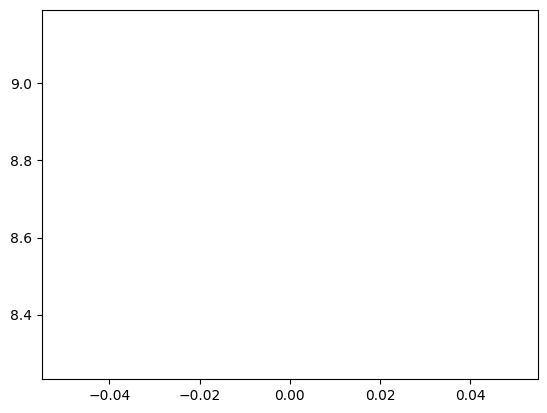

In [16]:
plt.plot(hh.history['loss'])

### Supervised fine tuning

From the trained SimCLR model, we extract the feature transformation part which includes the base encoder and the first two dense layers of the projection head. 

In [17]:
x = layers.Input(input_shape)

# same same
# _proj = models.Model(inputs=model._projector.inputs, outputs=model._projector.layers[3].output)
_proj = models.Model(inputs=model._projector.layers[0].input, outputs=model._projector.layers[3].output)

# _proj.summary()  # shows a concrete value for batch

f = _proj(model._encoder(x))

model_feature = models.Model(inputs=x, outputs=f, name='SimCLR_feature')

model_feature.summary()  # shows `None` for batch

Model: "SimCLR_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 128)            │       558,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,176 (92.11 MB)

 Trainable params: 557,952 (2.13 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Test the feature transformation model to see how it acts across the batch.

In [18]:
# eles = list(ds_train.take(1))[0]
eles = list(ds_train.take(1).as_numpy_iterator())[0]

xx = ops.take(eles[0][0], [2], axis=0)
yy = model_feature.predict(xx)  # apply on a single input
zz = model_feature.predict(eles[0][0])[2]  # apply on a batch of inputs then take the corresponding output

# yy = model._encoder.predict(xx)
# zz = model._encoder.predict(eles[0][0])[2]

# Comparison: NOT zero.
yy-zz

2024-06-18 12:52:30.855289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  1.7881393e-06,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -1.1920929e-06, -1.0132790e-06,
         0.0000000e+00, -2.3841858e-07,  4.1769817e-07,  0.0000000e+00,
         0.0000000e+00,  2.3841858e-07, -8.9406967e-07, -1.1920929e-07,
         5.3644180e-07,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  4.7683716e-07,  0.0000000e+00,
        -4.7683716e-07,  1.7881393e-07, -2.3841858e-07,  0.0000000e+00,
         2.3841858e-07, -8.3446503e-07, -1.1920929e-07,  0.0000000e+00,
         4.7683716e-07, -3.5762787e-07,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00, -7.1525574e-07,  0.0000000e+00,  3.5762787e-07,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.1920929e-06,
        -1.1920929e-06,  3.5762787e-07,  1.2293458e-06,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.25169

#### Classfication head and fine tuning

We add a classification head to the feature transformation network and fine tune the model on some new data.

Let's first prepare new data of few-shot learning style. This consists in splitting separately each category (i.e. a label) of data.

In [26]:
slider = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(64,64))
# fp = tempfile.mkdtemp()
# slider.serialize(str(workdir), compression='GZIP')
# slider.dataset = tf.data.Dataset.load(str(workdir), compression='GZIP')

preproc = preprocessing.get_mapping_supervised(labels)

splits = {'train':0.7, 'val':0.2, 'test':0.1}
batch_size = 64

n_classes = len(labels) + 1

Two equivalent ways of doing this: split before preprocess or preprocess before split.

In [45]:
# Way 1: split first

dw = utils.restore_cardinality(
    slider.dataset
)

dw_split = utils.split_dataset(dw, splits, ds_size=int(dw.cardinality()), labels=labels)

dw_train = dw_split['train']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(ds_size, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size, drop_remainder=True)
dw_test = dw_split['test']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(1, drop_remainder=True)

2024-06-18 13:49:16.274706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 13:49:16.277779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
# Way 2: preprocess first

dw = utils.restore_cardinality(
    slider.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)
)

dw_split = utils.split_dataset(dw, splits, ds_size=int(dw.cardinality()), labels=np.arange(n_classes))

dw_train = dw_split['train']\
    .shuffle(ds_size, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val'].batch(batch_size, drop_remainder=True)
dw_test = dw_split['test'].batch(1, drop_remainder=True)

2024-06-18 13:07:28.605078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 13:07:28.609527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
model_feature.trainable = False

model_clas = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_classes) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fine = models.Model(inputs=x, outputs=model_clas(model_feature(x)))

model_fine.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    # metrics=[metrics.SparseCategoricalAccuracy()]
)

In [ ]:
hh = model_fine.fit(
    dw_val,
    validation_data=dw_test,
    epochs=2
)